# Face & Text Extraction

**Contextualização**: O setor de fraudes apontou que existem clientes que se queixaram de não contratar serviços
específicos, como o crédito pessoal. Entretanto após o indicador de Detecção de vivacidade
(liveness), desenvolvido na disciplina de Computer Vision, ter apresentado um percentual de
vivacidade menor que 90% apontou a necessidade de uma nova validação do self da pessoa com o
documento.

## Objetivos do Trabalho

- Extração da Face, Nome e CPF do documento de identificação utilizado.
- Comparar a foto do documento de Identificação com uma Self-Photo. O modelo precisa ser calibrado para aceitar apenas semelhança acima de 90% de acertividade)
- Compara o Nome utilizado no documento de identificação com o comprovante de residência


### Definições:

1 - Serão aceitos como documento de identificação:
 - Carteira Nacional de Habilitação Brasileira emitida a partir de Junho de 2022.

 Exemplo:

  <img src="https://conteudo.imguol.com.br/c/entretenimento/ae/2022/06/03/nova-cnh-2022-1654284075548_v2_3x4.jpg" width="50%" alt="Imagem redimensionada">


 - Caretira de Identidade Nacional emitida a partir de Agosto de 2022.

 Exemplo:

   ![Modelo](https://www.gov.br/casacivil/pt-br/assuntos/noticias/2022/julho/nova-carteira-de-identidade-nacional-modelo-unico-a-partir-de-agosto/carteira-digital-de-transito3.jpeg/@@images/0e062563-cb8c-49f3-9d14-338006f6c5a7.png)

2 - Serão aceitos como comprovantes de residência: contas de água, luz ou gás em pdf.

  Exemplo:


  <img src="https://cdn.cidade-brasil.com.br/comprovante-residencia.webp" width="50%" alt="Imagem redimensionada">



## Preparação do ambiente de desenvolvimento

### 1 - Instalação de Pacotes do Python e importação de modulos.

In [1]:
# Instalação da biblioteca Boto3, sempre obter a última versão
!pip install boto3 --quiet
!pip install amazon-textract-response-parser --quiet


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.9/139.9 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 42.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.8/84.8 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 3.2 MB/s eta 0:00:00


In [2]:
# importa modulos
import boto3
import matplotlib.pyplot as plt
import matplotlib.image  as mpimg
from PIL import Image, ImageDraw
from trp import Document
import re


### Configurar as credências de acesso para os serviços de AI/ML da AWS

In [3]:
# AWS credentials and configuration
from google.colab import userdata

AWS_ACCESS_KEY_ID     = userdata.get('aws_access_key')
AWS_SECRET_ACCESS_KEY = userdata.get('aws_secret_key')
REGION_NAME           = 'us-east-1'

In [4]:
# Configuração dos Cliente do Boto3

textract_client = boto3.client('textract',
                                   aws_access_key_id=AWS_ACCESS_KEY_ID,
                                   aws_secret_access_key=AWS_SECRET_ACCESS_KEY,
                                   region_name=REGION_NAME)


rekognition_client = boto3.client('rekognition',
                                    aws_access_key_id=AWS_ACCESS_KEY_ID,
                                    aws_secret_access_key=AWS_SECRET_ACCESS_KEY,
                                    region_name=REGION_NAME)

### Clonagem do repositorio no Github

In [5]:
# Limpeza do diretorio local do Google Colab
%cd ..
!rm -rf fiap_8DTSR_cognitive_environments/

/


In [6]:
#Clonagem do repo
!git clone https://github.com/escardoso/fiap_8DTSR_cognitive_environments.git

Cloning into 'fiap_8DTSR_cognitive_environments'...
remote: Enumerating objects: 65, done.
remote: Counting objects: 100% (65/65), done.
remote: Compressing objects: 100% (57/57), done.
remote: Total 65 (delta 23), reused 32 (delta 7), pack-reused 0 (from 0)
Receiving objects: 100% (65/65), 13.04 MiB | 17.85 MiB/s, done.
Resolving deltas: 100% (23/23), done.


In [7]:
# acessar diretorio
%cd fiap_8DTSR_cognitive_environments/

/fiap_8DTSR_cognitive_environments


## Solução

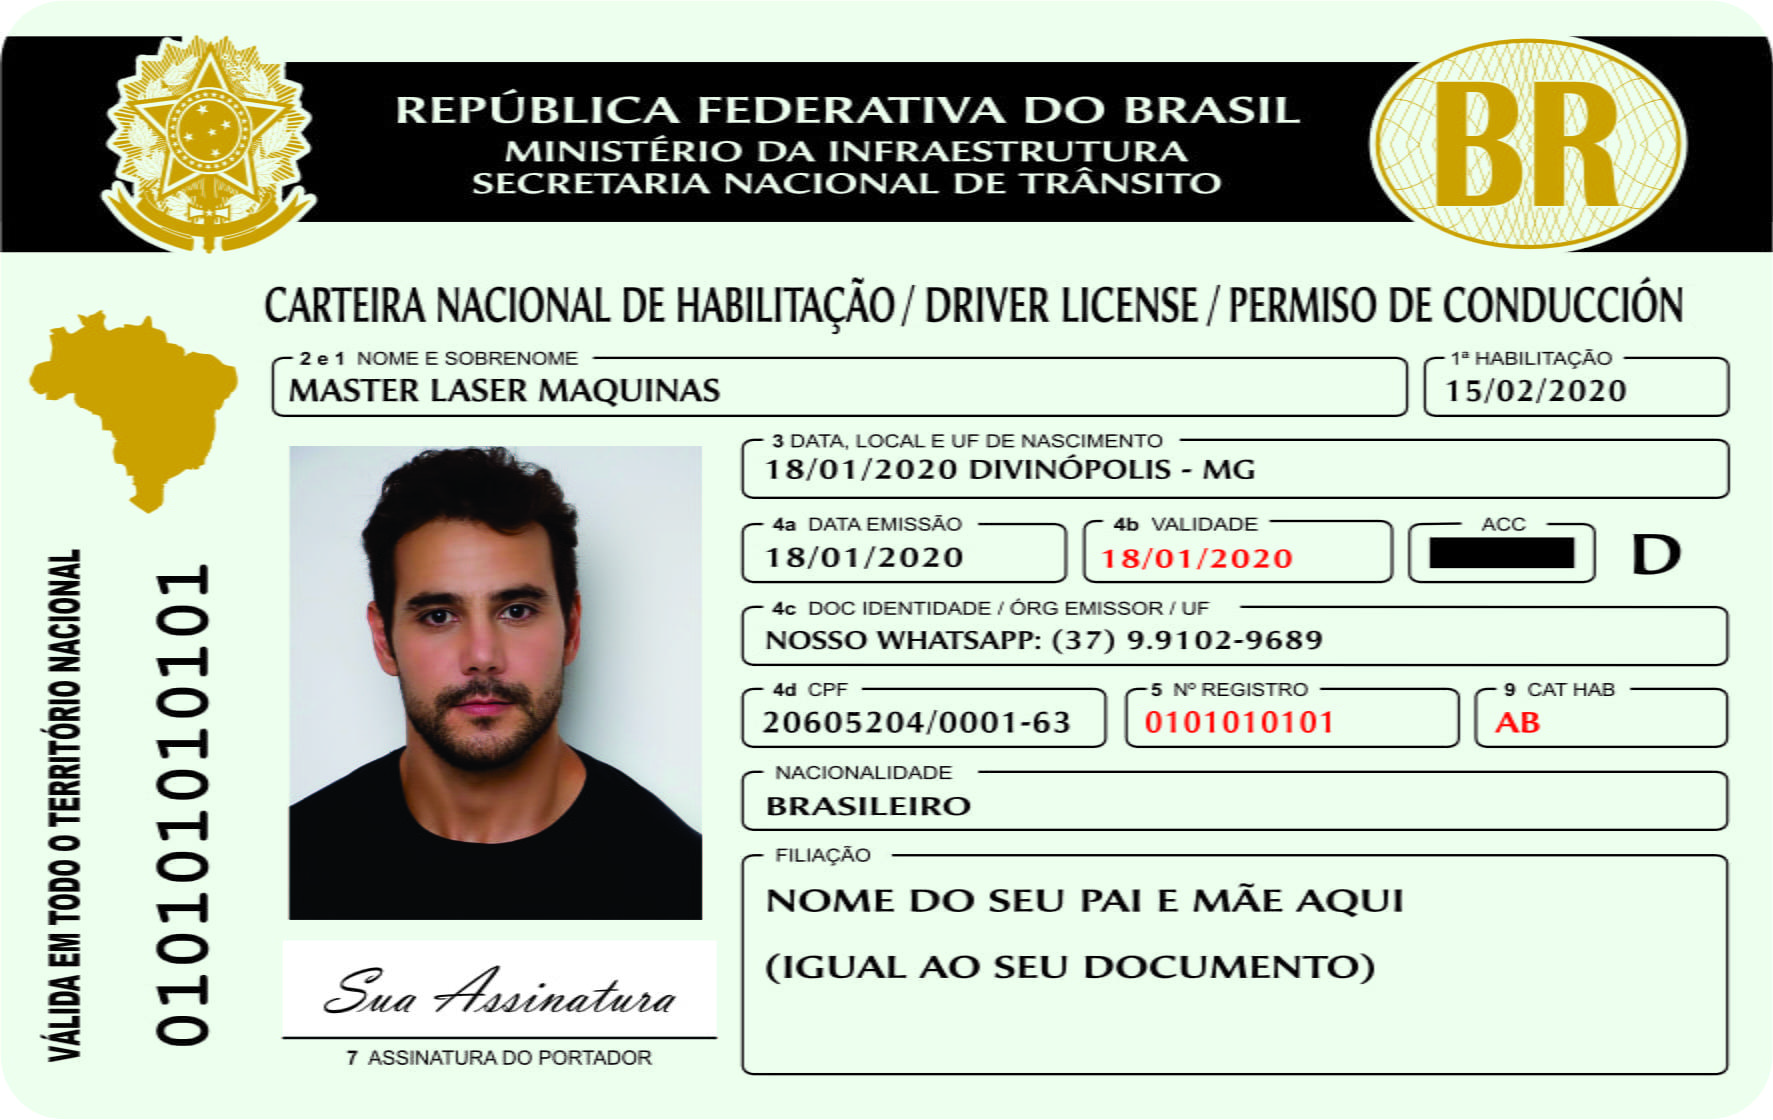

In [55]:
#Validar acesso as imagens
imagem = Image.open("imagens/carteira-nacional-de-habilitacao-1.jpg")
imagem

In [53]:
# Primeiro desafio: Extração da Face, Nome e CPF

def get_face_document(document_path):
  """Extract data from Identity Document using Amazon Textract and rekognition """
  try:
    with open(document_path, 'rb') as image_file: # Open the image file in binary read mode ('rb')
      image_bytes = image_file.read()             # Read the image data into bytes

    response = rekognition_client.detect_faces(
      Image={'Bytes': image_bytes},
      Attributes=['ALL']
    )

    #Detect faces in the document

    document_face = response['FaceDetails'][0]  # Assuming one face in the document

    return print("Number of faces detected: {}".format(len(response['FaceDetails'])))

  except Exception as e:
    print(f"Error processing Identification: {e}")
    return None

def extract_doc_information(document_path):
    """Extract data from Identity Document using Amazon Textract and rekognition """
    try:
        with open(document_path, "rb") as document:
            response2 = textract_client.analyze_document(
                Document={
                    'Bytes': document.read(),
                },
                FeatureTypes=["FORMS"])

        doc = Document(response2)
        # Store Name and CPF in variables
        extracted_name = None
        extracted_cpf  = None
        for page in doc.pages:
            for field in page.form.fields:
                key   = str(field.key)
                value = field.value
                # Check for different key variations for Name
                if (key == '2e1 NOME E SOBRENOME'):
                    key = '2e1 NOME E SOBRENOME'
                    field = page.form.getFieldByKey(key)
                    extracted_name = field.value
                    # print(extracted_name) #for troubleshooting

                if (key == '2 e 1 NOME E SOBRENOME'):
                    key = '2 e 1 NOME E SOBRENOME'
                    field = page.form.getFieldByKey(key)
                    extracted_name = field.value
                    # print(extracted_name)

                if (key == 'NOME'):
                    key = 'NOME'
                    field = page.form.getFieldByKey(key)
                    extracted_name = field.value

                if (key == 'Name/Name'):
                    key = 'Name/Name'
                    field = page.form.getFieldByKey(key)
                    extracted_name = field.value
                    # print(extracted_name)

                # Check for different key variations for CPF
                if (key == 'Recides Carral CPF F Femorat Number'):
                    key = 'Recides Carral CPF F Femorat Number'
                    field = page.form.getFieldByKey(key)
                    extracted_cpf = field.value
                    # print(extracted_cpf)

                if (key == '4d CPF'):
                    key = '4d CPF'
                    field = page.form.getFieldByKey(key)
                    extracted_cpf = field.value
                    # print(extracted_cpf)

                if (key == 'CPF'):
                    key = 'CPF'
                    field = page.form.getFieldByKey(key)
                    extracted_cpf = field.value

            if extracted_name and extracted_cpf:
                break  # Stop searching across pages after finding both

        return extracted_name, extracted_cpf  # Return the values

    except Exception as e:
        print(f"Error processing Identification: {e}")
        return None, None

In [57]:
# Segundo desafio: Comparar faces

def compare_faces(document_path, self_path, similarity_threshold=90):
    """Compare faces using Amazon Rekognition"""
    try:
        # Read document image into bytes
        with open(document_path, 'rb') as document_file:
            document_bytes = document_file.read()

        # Read self-image into bytes
        with open(self_path, 'rb') as self_file:
            self_bytes = self_file.read()

        response = rekognition_client.compare_faces(
            SourceImage={'Bytes': document_bytes},  # Pass bytes
            TargetImage={'Bytes': self_bytes},      # Pass bytes
            SimilarityThreshold=similarity_threshold
        )

        if response['FaceMatches']:
          print("Faces Matched")
        else:
          print("Faces not Matched")



    except Exception as e:
        print(f"Error processing Identification: {e}")
        return None

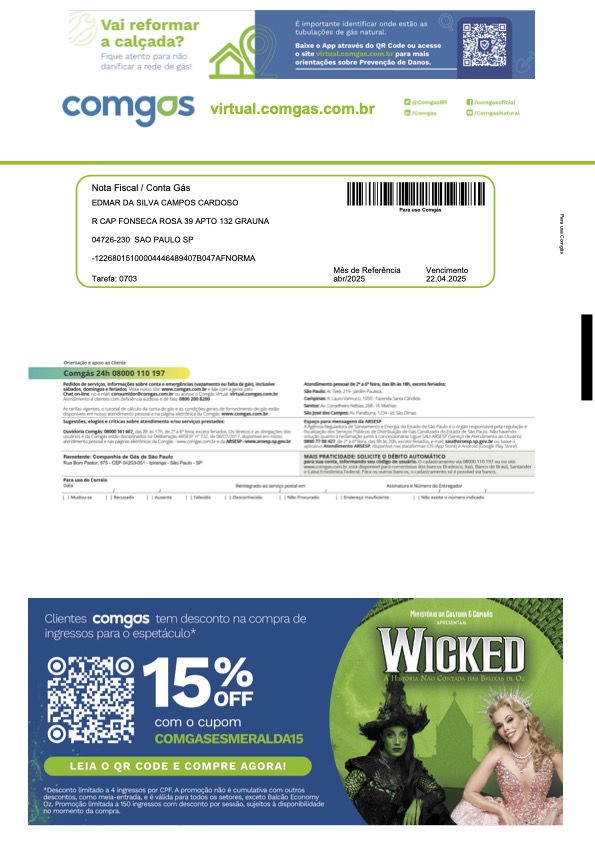

In [14]:
#Validar acesso as imagens
# imagem = Image.open("docment/comprovante_residencia_conta_energia.jpg")
imagem = Image.open("docment/comprovante_residencia_conta_gas.jpg")
imagem

In [62]:
def extract_and_search_full_name(residence_document_path, full_name_to_search):
    with open(residence_document_path, 'rb') as document: # Changed document_path to residence_document_path
        response = textract_client.detect_document_text(
            Document={'Bytes': document.read()}
        )
    extracted_text = ''
    for item in response['Blocks']:
        if item['BlockType'] == 'LINE':
            extracted_text += item['Text'] + '\n'

    # Search for the Full Name using regex
    # Convert full_name_to_search to string if it's a FieldValue object
    if not isinstance(full_name_to_search, str):
        full_name_to_search = str(full_name_to_search)
    match = re.search(full_name_to_search, extracted_text, re.IGNORECASE)

    if match:
        print('The name on the proof of residence is the same as the name on the identity document')
        return match.group(0)
    else:
        print('The name on the proof of residence is NOT the same as the name on the identity document')
        return None

## Testing the Solution

In [64]:
# Loading documents and images:

document_path = 'imagens/Doc_tieris.jpg'
self_path     = 'imagens/self_tieris.jpg'
residence_document_path = "docment/Comprovante_tieris.png"

# # Extract the Face, Full Name and the CPF Number from the identity document
extracted_full_information=extract_doc_information(document_path)

extracted_name = extracted_full_information[0]
extracted_cpf  = extracted_full_information[1]

print(f'Full Name: {extracted_name}')
print(f'CPF: {extracted_cpf}')

# Get Face in Document

get_face_document(document_path)

# Compare Face from the Document with Self

compare_faces(document_path,self_path)

# Compare the name from identity document with the the proof of residence document

extracted_full_name = extract_and_search_full_name(residence_document_path, extracted_name)
print(extracted_full_name)



Full Name: TIERIS GABRIEL KUHLER VALENTE
CPF: 012.717.910-05
Number of faces detected: 1
Faces Matched
The name on the proof of residence is the same as the name on the identity document
TIERIS GABRIEL KUHLER VALENTE
